# Stress Levels in Canada (v2)
### Geography of Stress and Health in the Canadian Community Health Survey 2022

## Project Overview

**Stress Levels in Canada (v2)** is a continuation of an earlier exploration of stress using the Canadian Community Health Survey. It is not a direct update of the initial project, but a follow-up focused specifically on **geospatial analysis**.

### Key Differences from Version 1

**Geographic focus**  
  - **v1:** Mapped stress and health factors at the *provincial and territorial* level.  
  - **v2:** Shifts to a more detailed geography using *grouped Health Regions*.

**Scope of analysis**  
  - **v1:** Included extensive EDA across 17 variables representing demographic, economic, social, and health-related factors.  
  - **v2:** Narrows the scope to geography and **three variables**: Perceived health, Perceived mental health, Perceived life stress. 

**Methods**  
  - **v2** intentionally does **not** include deep statistical testing or exploratory machine learning.  
  - The focus is visual, geographic, and comparative.

**Survey basis**  
  - **v1:** Based on the 2019–2020 CCHS cycle.  
  - **v2:** Uses the more recent **2022** survey.

### Data Source

This version of the project is based on the **Canadian Community Health Survey, 2022** — a comprehensive initiative by Statistics Canada, which regularly surveys to support improvements in health services and address health-related challenges across the population. The data was published in June 2024 (updated September 2025) as the [Canadian Community Health Survey: Public Use Microdata File, 2019 to 2022](https://www150.statcan.gc.ca/n1/pub/82m0013x/82m0013x2024001-eng.htm), and is used here for educational and research purposes.

The [study documentation](https://abacus.library.ubc.ca/dataset.xhtml?persistentId=hdl:11272.1/AB2/QIKXXT) is available via Borealis, the Canadian Dataverse Repository. It can be accessed under the **Metadata** tab by selecting the **Export Metadata** option.

*Adapted from Statistics Canada, Canadian Community Health Survey: Public Use Microdata File, 2019 to 2022, December 9, 2025. This does not constitute an endorsement by Statistics Canada of this product.*


The geospatial data comes from the **Health Regions: Boundaries and Correspondence with Census Geography, December 2022** shapefile, released on March 1, 2023, by Statistics Canada.  
Source: [Health region boundary files](https://www150.statcan.gc.ca/n1/pub/82-402-x/2023001/hrbf-flrs-eng.htm) (Cartographic boundary files – ArcGIS – Canada).

*Adapted from Statistics Canada, Health Regions: Boundaries and Correspondence with Census Geography, December 2022,  December 9, 2025. This does not constitute an endorsement by Statistics Canada of this product.*



### Project Structure

#### 1. Data Cleaning and Preparation
The shapefile is examined and merged using grouped health regions derived from the survey. The raw CCHS 2022 data is cleaned, filtered, and prepared for geospatial analysis.

#### 2. Analysis of Stress and Health Geography
This section explores the geographic distribution of perceived health, perceived mental health, and perceived life stress, with a focus on regional patterns and variation.

#### 3. Tableau Presentation
Key findings are summarized and presented through interactive dashboards for clear and accessible interpretation.

## 1. Data Cleaning and Preparation

The goal of the first part is to process the shapefile into a suitable geospatial dataframe and prepare the survey data for mapping and analysis.

### 1.1 Processing Geospatial Data

The main objective of this step is to prepare a geospatial dataframe that matches the health-region geography used in the CCHS 2022 survey. Several challenges arise in this process:

1. **Health region boundaries change frequently.**  
   Health regions are managed independently by provincial and territorial authorities, with no centralized coordination. Boundaries and region IDs may be updated locally, and these updates are incorporated into national boundary files with delays. As a result, shapefiles from different years may reflect accumulated changes inconsistently. While correspondence files exist, resolving mismatches often requires additional manual investigation.

2. **The survey includes two geographic variables:**  
   - **Province ID**  
   - **Grouped health region ID (GEODVHR4)**  

   According to the *Derived Variable Specifications* for CCHS 2022, GEODVHR4 represents the health region derived from the respondent’s postal code and the sampling frame at the time of data collection. Statistics Canada provides partial grouping logic for these regions. However, the grouped identifiers do not perfectly align with the boundary files of 2022. Completing the mapping requires cross-referencing multiple boundary releases from the 2010s and resolving inconsistencies manually.


In [5]:
# Import the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

The first step is to examine the geographical codes provided in the CCHS dataset.

In [7]:
# Read the data set and show geographic codes
df = pd.read_csv("/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/data/CSV/Data_Données/pumf_cchs.csv")
df[['GEOGPRV', 'GEODGHR4']].head()

,GEOGPRV,GEODGHR4
0,35,35970
1,24,24916
2,35,35941
3,59,59911
4,24,24913


The two codes represent provincial and health region levels. GEODGHR4 encodes both provincial and health-region information.  
The first two digits represent the province or territory, followed by a “9” separator, and the final two digits identify the grouped health region within that province.

In [9]:
# Read the shapefile and show first five rows
hr_map = gpd.read_file('/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/data/hr_map_simplified_2022.shp .shp')

hr_map.head()

,HR_UID,ENGNAME,FRENAME,DGUID,geometry
0,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,2022A00071011,"MULTIPOLYGON (((8824262.857 1952006.689, 88242..."
1,1012,Central Regional Health Authority,Central Regional Health Authority,2022A00071012,"MULTIPOLYGON (((8794613.106 1984585.209, 87945..."
2,1013,Western Regional Health Authority,Western Regional Health Authority,2022A00071013,"MULTIPOLYGON (((8560556.766 1890103.897, 85605..."
3,1014,Labrador-Grenfell Regional Health Authority,Labrador-Grenfell Regional Health Authority,2022A00071014,"MULTIPOLYGON (((8575477.163 2227629.649, 85754..."
4,1100,Prince Edward Island,Île-du-Prince-Édouard,2022A00071100,"MULTIPOLYGON (((8326621.806 1599735.974, 83265..."


In [10]:
from shapely.geometry import Polygon, MultiPolygon

def remove_holes(geom):
    if geom.geom_type == "Polygon":
        return Polygon(geom.exterior)
    elif geom.geom_type == "MultiPolygon":
        return MultiPolygon([Polygon(p.exterior) for p in geom.geoms])
    return geom

hr_map = hr_map.copy()
hr_map["geometry"] = hr_map.geometry.apply(remove_holes)

HR_UID encodes the health regions in the 2022 boundary file.

Next, the counts of IDs in the survey and boundary files are compared:

In [12]:
print(df['GEODGHR4'].nunique())
print(hr_map['HR_UID'].nunique())

91
104


CCHS 2022 data contains 91 grouped health regions, whereas the 2022 boundary file lists 104 actual health regions in Canada.

In the next step, a correspondence dataframe is created to map each actual health region (`HR_UID`) from the shapefile to the grouped health region (`GEODGHR4`) from CCHS data.

In [14]:
# Ensure both codes are in a string format
df['GEODGHR4'] = df['GEODGHR4'].astype(str)
hr_map['HR_UID'] = hr_map['HR_UID'].astype(str)

The following dictionary is based primarily on the correspondence tables from *Derived Variable Specifications* for CCHS 2022. Several outdated IDs for Saskatchewan and Ontario were corrected after examining earlier correspondence files.

In [16]:
# Create a mapping dictionary
mapping_ids = {
    # Newfoundland & Labrador
    10913: [1013, 1014],            # Labrador-Grenfell + Western Regions

    # New Brunswick
    13904: [1304, 1305],            # Edmundston + Campbellton
    13906: [1306, 1307],            # Bathurst + Miramichi

    # Ontario
    35939: [3550],                  # Huron + Perth (merged)
    35947: [3547, 3563],            # North Bay Parry Sound + Timiskaming
    35949: [3549, 3556],            # Northwestern + Porcupine
    35954: [3550],                  # Huron + Perth (merged)

    # Manitoba
    46903: [4603, 4604],            # Interlake-Eastern + Northern

    # Saskatchewan
    47901: [4701, 4702, 4703],      # Sun Country + Five Hills + Cypress
    47905: [4705, 4708],            # Sunrise + Kelsey Trail
    47907: [4707, 4710],            # Heartland + Prairie North
    47909: [4709, 4714],            # Prince Albert Parkland + Mamawetan/Keewatin/Athabasca
    47908: [4704],                  # Saskatoon (one-to-one)
    47910: [4701, 4702, 4703],      # North Central West → merged polygon
    47914: [4701, 4702, 4703],      # Far North → merged polygon
    47903: [4701, 4702, 4703],      # North Central East → merged polygon

    # British Columbia
    59951: [5951, 5953],            # Northwest + Northeast HSDA

    # Territories
    60901: [6001, 6101, 6201],      # Yukon + NWT + Nunavut
}

In the next step, the correspondence dataframe is created to map each actual health region (HR_UID) from the shapefile to the grouped health region (GEODGHR4) in the CCHS 2022 data.

In [18]:
# 1. normalize mapping (keys 5-char, values list of 4-char strings)
mapping_str = { str(k).zfill(5): [str(v).zfill(4) for v in vs] for k, vs in mapping_ids.items() }

# 2. get unique GEODGHR4 values from your dataframe (normalized)
codes = pd.Series(df['GEODGHR4'].astype(str).str.strip().str.zfill(5).unique())

# 3. build exploded rows
rows = []
for code in codes:
    if code in mapping_str:
        for uid in mapping_str[code]:
            rows.append({'GEODGHR4': code, 'HR_UID': uid})
    else:
        uid = (code[:2] + code[3:]).zfill(4)
        rows.append({'GEODGHR4': code, 'HR_UID': uid})

# 4. corresp DataFrame (one row per real HR)
corresp = pd.DataFrame(rows)
# corresp now has columns: 'GEODGHR4' (5-char) and 'HR_UID' (4-char), exploded as requested
corresp.head()

,GEODGHR4,HR_UID
0,35970,3570
1,24916,2416
2,35941,3541
3,59911,5911
4,24913,2413


To investigate the correspondence in more detail, a simple check of unique health region IDs can be performed. This helps confirm if each HR_UID from the shapefile has been assigned to a grouped health region and if mismatches or missing links remain.

In [20]:
print('Unique HRs in data: ', set(corresp['HR_UID'].unique()) - set(hr_map['HR_UID'].unique()))
print('Unique HRs in shapefile: ', set(hr_map['HR_UID'].unique()) - set(corresp['HR_UID'].unique()))

Unique HRs in data:  {'4709', '4714', '4708', '4710'}
Unique HRs in shapefile:  {'2418', '2410', '2417'}


After applying the correspondence dictionary, several mismatches remain.  
Health region IDs **4714, 4710, 4708, and 4709** from the survey do not correspond to any HR_UIDs in the boundary file. Conversely, health regions **2417, 2418, and 2410** in the shapefile do not appear in the survey data at all.

As **grouped HR codes in CCHS do not map one-to-one** to the actual 2022 health region boundaries, this mismatch reflects a **lag between survey geography and administrative updates**. In particular, the health regions of **Saskatchewan (47)** were restructured after sampling, resulting not only in mergers but also in the creation of new IDs. To preserve survey consistency, the grouped CCHS regions are retained in the correspondence table but linked directly to the 2022 boundary geography.

The three northern regions of **Quebec (24)** that appear in the 2022 boundary file have no corresponding survey data, meaning CCHS did not collect responses for these areas under distinct grouped IDs.

Such mismatches are expected when survey geography and boundary geography evolve at different rates, and when the CCHS uses a geographic grouping system that does not reflect every boundary update in real time.

These discrepancies should not be viewed as errors but rather as a structural feature of CCHS 2022 geography.

As the correspondence dataframe is now complete and every grouped health region from the CCHS data is linked to one or more actual health region IDs (HR_UID), the next step is to merge these grouped IDs into the boundary file. This merge will allow the shapefile geometry to inherit the GEODGHR4 codes, enabling geospatial mapping of the survey data.

In [23]:
# Create an updated map by merging grouped IDs
grouped_map = corresp.merge(hr_map, on='HR_UID')
grouped_map.head()

,GEODGHR4,HR_UID,ENGNAME,FRENAME,DGUID,geometry
0,35970,3570,York Regional Health Unit,Circonscription sanitaire régionale de York,2022A00073570,"POLYGON ((7217707.154 1020013.129, 7218768.126..."
1,24916,2416,Région de la Montérégie,Région de la Montérégie,2022A00072416,"MULTIPOLYGON (((7565318.4 1166717.857, 7565236..."
2,35941,3541,"Kingston, Frontenac and Lennox and Addington H...","Circonscription sanitaire de Kingston, Fronten...",2022A00073541,"MULTIPOLYGON (((7401834.969 1014030.731, 74017..."
3,59911,5911,East Kootenay Health Service Delivery Area,East Kootenay Health Service Delivery Area,2022A00075911,"POLYGON ((4496402.26 2170701.066, 4496367.266 ..."
4,24913,2413,Région de Laval,Région de Laval,2022A00072413,"MULTIPOLYGON (((7609428.706 1239495.231, 76094..."


<Axes: >

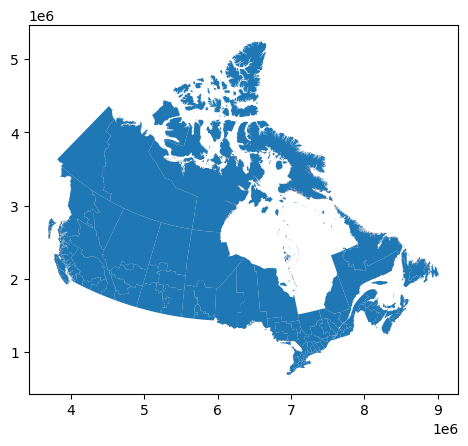

In [24]:
# Turn the new dataframe into a geospatial
grouped_map = gpd.GeoDataFrame(grouped_map, geometry='geometry')
grouped_map["geometry"] = grouped_map["geometry"].buffer(0)

grouped_map.plot()

The grouped map clearly shows that the geography of **Quebec** is incomplete. This results in visible gaps on the map and reflects the fact that these areas were **not sampled or not assigned a distinct grouped HR code** in the 2022 survey.

To complete the merge, the next step is to dissolve the polygons by the grouped health region IDs from CCHS.

<Axes: >

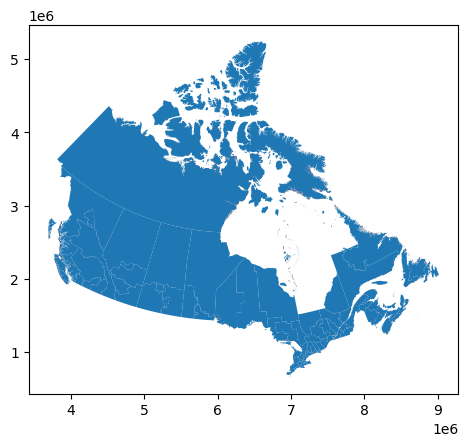

In [26]:
# Dissolve the geometry by grouped health regions
dissolved_map = grouped_map.dissolve(by="GEODGHR4")
dissolved_map.plot()

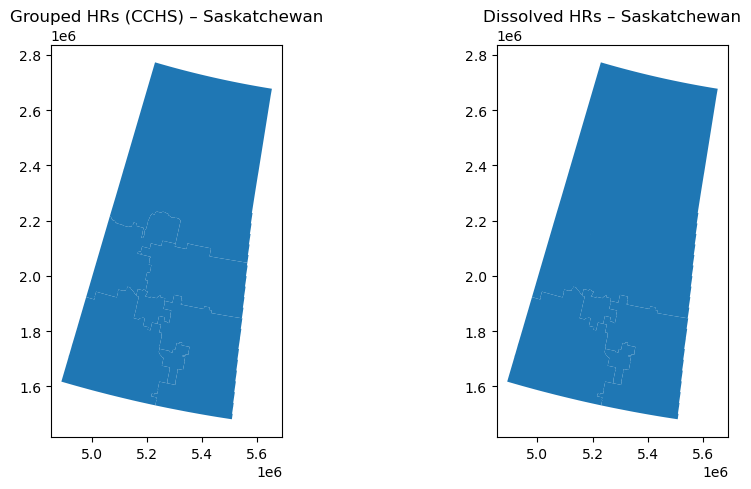

In [27]:
# Select the province of Saskatchewan
sk_g = grouped_map[grouped_map.GEODGHR4.astype(str).str.startswith("47")]
sk_d = dissolved_map[dissolved_map.index.astype(str).str.startswith("47")]

# Plot the maps of Saskatchewan
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sk_g.plot(ax=axes[0])
axes[0].set_title("Grouped HRs (CCHS) – Saskatchewan")

sk_d.plot(ax=axes[1])
axes[1].set_title("Dissolved HRs – Saskatchewan")

plt.tight_layout()
plt.show()

After dissolving the polygons, the boundaries of the health regions become aligned with the grouped IDs used in the survey.

In [29]:
# Reset the index
dissolved_map = dissolved_map.reset_index()

In the next step, a province- and territory-level geospatial dataframe will be created.

In [31]:
# Rename the health region column and create a separate column for the province ID
dissolved_map = dissolved_map.rename(columns={'GEODGHR4': 'hr_grouped'})
dissolved_map['province_id'] = dissolved_map['hr_grouped'].str[:2]

dissolved_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   hr_grouped   90 non-null     object  
 1   geometry     90 non-null     geometry
 2   HR_UID       90 non-null     object  
 3   ENGNAME      90 non-null     object  
 4   FRENAME      90 non-null     object  
 5   DGUID        90 non-null     object  
 6   province_id  90 non-null     object  
dtypes: geometry(1), object(6)
memory usage: 5.1+ KB


<Axes: >

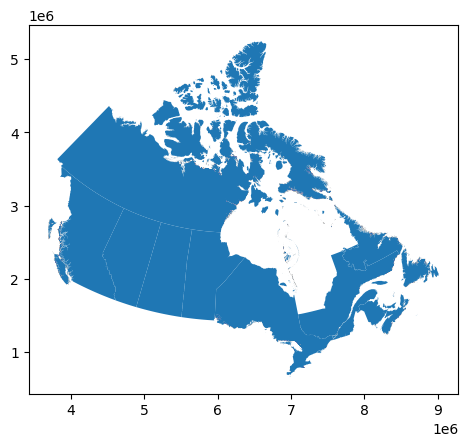

In [32]:
province_map = dissolved_map.dissolve(by='province_id')
province_map.plot()

In [33]:
province_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 11 entries, 10 to 60
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    11 non-null     geometry
 1   hr_grouped  11 non-null     object  
 2   HR_UID      11 non-null     object  
 3   ENGNAME     11 non-null     object  
 4   FRENAME     11 non-null     object  
 5   DGUID       11 non-null     object  
dtypes: geometry(1), object(5)
memory usage: 916.0+ bytes


A simplified province-level geospatial dataframe will be created for use in the visualizations that follow.

In [35]:
# Reset index so province_id becomes a column
province_map = province_map.reset_index()

# Drop health refion columns
province_map = province_map.drop(
    columns=['hr_grouped', 'HR_UID', 'ENGNAME', 'FRENAME', 'DGUID']
)

In [36]:
province_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   province_id  11 non-null     object  
 1   geometry     11 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 308.0+ bytes


In [37]:
# Convert province_id to int to match dictionary keys
province_map['province_id'] = province_map['province_id'].astype(int)

# Create province name dictionary
province_dict = {
    10: "Newfoundland and Labrador",
    11: "Prince Edward Island",
    12: "Nova Scotia",
    13: "New Brunswick",
    24: "Quebec",
    35: "Ontario",
    46: "Manitoba",
    47: "Saskatchewan",
    48: "Alberta",
    59: "British Columbia",
    60: "Territories (YT/NT/NU)"
}

# Map province_id to province_name
province_map['province_name'] = province_map['province_id'].map(province_dict)

# Quick check
province_map[['province_id', 'province_name']]

,province_id,province_name
0,10,Newfoundland and Labrador
1,11,Prince Edward Island
2,12,Nova Scotia
3,13,New Brunswick
4,24,Quebec
5,35,Ontario
6,46,Manitoba
7,47,Saskatchewan
8,48,Alberta
9,59,British Columbia


In [38]:
# Convert province_id to int to match dictionary keys
dissolved_map['province_id'] = dissolved_map['province_id'].astype(int)

# Map province_id to province_name
dissolved_map['province_name'] = dissolved_map['province_id'].map(province_dict)

# Quick check
dissolved_map[['province_id', 'province_name']]

,province_id,province_name
0,10,Newfoundland and Labrador
1,10,Newfoundland and Labrador
2,10,Newfoundland and Labrador
3,11,Prince Edward Island
4,12,Nova Scotia
...,...,...
85,59,British Columbia
86,59,British Columbia
87,59,British Columbia
88,59,British Columbia


### 1.2 Preparing data for plotting

The preparation of the survey data for plotting follows steps similar to those in version 1 of the project. The main difference is the selection of survey fields, which here is limited to perceived health, perceived mental health, and perceived life stress. In addition, the health region and province codes are included.

In the first step, the health region identifiers are checked for consistency with the prepared geospatial data:

In [41]:
# Check the matching of the dataframes for health region IDs
set(df['GEODGHR4'].unique()) - set(dissolved_map['hr_grouped'].unique())

{'47909'}

An additional check revealed one more inconsistency: according to the Derived Variable Specifications of CCHS 2022, the grouped health region ID 47909 from the survey was originally linked to actual health regions 4709 and 4714. However, at the time of publication, the IDs of these regions had changed. The next step will include the data of the Prince Albert Parkland Regional Health Authority, formerly marked as 4709, to the region of Far North (4701).

In [43]:
# Replace the health region IDs
df['GEODGHR4'] = df['GEODGHR4'].replace('47909', '47901')
set(df['GEODGHR4'].unique()) - set(dissolved_map['hr_grouped'].unique())

set()

The five fields will be selected from the initial data into the **cchs** subset

In [45]:
# Create a subset for plotting
select = ['GEOGPRV', 'GEODGHR4', 'GEN_01', 'GEN_05', 'GEN_10']
cchs = df[select]
cchs.head(5)

,GEOGPRV,GEODGHR4,GEN_01,GEN_05,GEN_10
0,35,35970,3,3,1
1,24,24916,3,3,3
2,35,35941,3,4,4
3,59,59911,2,3,3
4,24,24913,3,4,3


The encoded column names will be changed to more descriptive names for clarity in the analysis.

In [47]:
# Create a renaming dictionary
rename_dict = {
    'GEOGPRV': 'province_id',
    'GEODGHR4': 'hr_grouped',
    'GEN_01': 'gen_health',
    'GEN_05': 'mental_health',
    'GEN_10': 'life_stress'
}

#Rename columns
cchs = cchs.copy()
cchs.rename(columns=rename_dict, inplace=True)
cchs.head()

,province_id,hr_grouped,gen_health,mental_health,life_stress
0,35,35970,3,3,1
1,24,24916,3,3,3
2,35,35941,3,4,4
3,59,59911,2,3,3
4,24,24913,3,4,3


After renaming the columns, the subset values will also be transformed to more descriptive labels. The next step will create a column with the province names

In [49]:
# Create a dictionary of province names according to province code
province_dict = {
    10: "Newfoundland and Labrador",
    11: "Prince Edward Island",
    12: "Nova Scotia",
    13: "New Brunswick",
    24: "Quebec",
    35: "Ontario",
    46: "Manitoba",
    47: "Saskatchewan",
    48: "Alberta",
    59: "British Columbia",
    60: "Territories (YT/NT/NU)"
}

# Create a new province name column by mapping the dictionary
cchs['province_name'] = cchs['province_id'].map(province_dict)
cchs.head()

,province_id,hr_grouped,gen_health,mental_health,life_stress,province_name
0,35,35970,3,3,1,Ontario
1,24,24916,3,3,3,Quebec
2,35,35941,3,4,4,Ontario
3,59,59911,2,3,3,British Columbia
4,24,24913,3,4,3,Quebec


The CCHS Data Dictionary encodes the responses with numbers. For clarity, these will be converted back into categorical variables. The digit 9 represents the response "Not Stated", so any responses containing this value will be excluded from the subset.

In [51]:
cols = ["gen_health", "mental_health", "life_stress"]

# keep only rows where none of these columns == 9
cchs = cchs[~cchs[cols].eq(9).any(axis=1)]

# Chech the result
print(cchs.gen_health.unique(), cchs.mental_health.unique(), cchs.life_stress.unique())
print(cchs.shape)

[3 2 4 1 5] [3 4 5 2 1] [1 3 4 2 5]
(66105, 6)


In [52]:
# Create a dictionary for mapping the values to codes
value_maps = {
    'gen_health': {
        1: 'Excellent',
        2: 'Very good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor'
    },
    'mental_health': {
        1: 'Excellent',
        2: 'Very good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor'
    },
    'life_stress': {
        1: 'Not at all stressful',
        2: 'Not very stressful',
        3: 'A bit stressful',
        4: 'Quite a bit stressful',
        5: 'Extremely stressful'
    },
}

In [53]:
# Apply the map
for col, mapping in value_maps.items():
    if col in cchs.columns:
        cchs[col] = cchs[col].map(mapping)
cchs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66105 entries, 0 to 67078
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   province_id    66105 non-null  int64 
 1   hr_grouped     66105 non-null  object
 2   gen_health     66105 non-null  object
 3   mental_health  66105 non-null  object
 4   life_stress    66105 non-null  object
 5   province_name  66105 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.5+ MB


In [54]:
# Change the datatype of province ID to string for consistency
cchs['province_id'] = cchs['province_id'].astype(str)
cchs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66105 entries, 0 to 67078
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   province_id    66105 non-null  object
 1   hr_grouped     66105 non-null  object
 2   gen_health     66105 non-null  object
 3   mental_health  66105 non-null  object
 4   life_stress    66105 non-null  object
 5   province_name  66105 non-null  object
dtypes: object(6)
memory usage: 3.5+ MB


## 2. Analysis of Stress and Health Geography

The goal of this second version of the Stress Levels in Canada project is to examine the geographic distribution of self-perceived general health, mental health, and life stress across Canada, with a particular focus on the health region level. In the first version, province-level mapping showed only limited variation in stress levels. Moving to a more granular geographic scale helps identify whether meaningful differences appear within provinces.

Health region boundaries follow census geography and are shaped by population distribution. Densely populated areas contain more, smaller health regions, while sparsely populated areas have fewer and much larger ones. In general, this structure allows exploration of whether population density is related to differences in perceived health and stress.

The following analysis is based on three types of maps:
- Provincial level
- Health region level
- Zoomed-in views of provinces containing the largest urban centres

Before plotting, the subset is extended with numerical variables ranging from 1 to 5 for each category. These values reflect the level of perceived health or stress for analytical clarity and do not correspond to the original CCHS survey codes.

In [57]:
# Map ordered categories to numeric values
def map_cat_to_num(series, order):
    mapping = {cat: i+1 for i, cat in enumerate(order)}
    return series.map(mapping)

# Define the ordered scales
health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
stress_order = ['Not at all stressful', 'Not very stressful', 'A bit stressful', 'Quite a bit stressful', 'Extremely stressful']

# Create new numeric columns
cchs['gen_health_num'] = map_cat_to_num(cchs['gen_health'], health_order)
cchs['mental_health_num'] = map_cat_to_num(cchs['mental_health'], health_order)
cchs['life_stress_num'] = map_cat_to_num(cchs['life_stress'], stress_order)

# Check the result
cchs.head()

,province_id,hr_grouped,gen_health,mental_health,life_stress,province_name,gen_health_num,mental_health_num,life_stress_num
0,35,35970,Good,Good,Not at all stressful,Ontario,3,3,1
1,24,24916,Good,Good,A bit stressful,Quebec,3,3,3
2,35,35941,Good,Fair,Quite a bit stressful,Ontario,3,2,4
3,59,59911,Very good,Good,A bit stressful,British Columbia,4,3,3
4,24,24913,Good,Fair,A bit stressful,Quebec,3,2,3


### Provincial level

To visualize variation across provinces, the numerical features are aggregated by computing their average values within each province.

In [60]:
# Calculate province-level means
province_means = cchs.groupby('province_name').agg({
    'gen_health_num': 'mean',
    'mental_health_num': 'mean',
    'life_stress_num': 'mean'
}).reset_index()

# Check the result
province_means.head()

,province_name,gen_health_num,mental_health_num,life_stress_num
0,Alberta,3.508061,3.522838,2.797386
1,British Columbia,3.438348,3.495427,2.775781
2,Manitoba,3.492414,3.521724,2.744138
3,New Brunswick,3.359143,3.530066,2.691928
4,Newfoundland and Labrador,3.431213,3.605220,2.647091


In the next step, the calculated averages are merged into the provincial geospatial dataframe and then plotted side by side for comparison.

In [62]:
# Merge the calculation into the province map
province_map_mean_val = province_map.merge(
    province_means,
    on='province_name',
    how='left'
)

# Check the result
province_map_mean_val.head()

,province_id,geometry,province_name,gen_health_num,mental_health_num,life_stress_num
0,10,"MULTIPOLYGON (((7708245.209 2889531.463, 77081...",Newfoundland and Labrador,3.431213,3.605220,2.647091
1,11,"MULTIPOLYGON (((8265314.709 1617815.76, 826500...",Prince Edward Island,3.541451,3.585492,2.689119
2,12,"MULTIPOLYGON (((8268209.734 1249945.94, 826811...",Nova Scotia,3.361133,3.433124,2.738788
3,13,"MULTIPOLYGON (((8068836.606 1411308.137, 80688...",New Brunswick,3.359143,3.530066,2.691928
4,24,"MULTIPOLYGON (((7564924.069 1166445.4, 7563496...",Quebec,3.656718,3.879520,2.551044


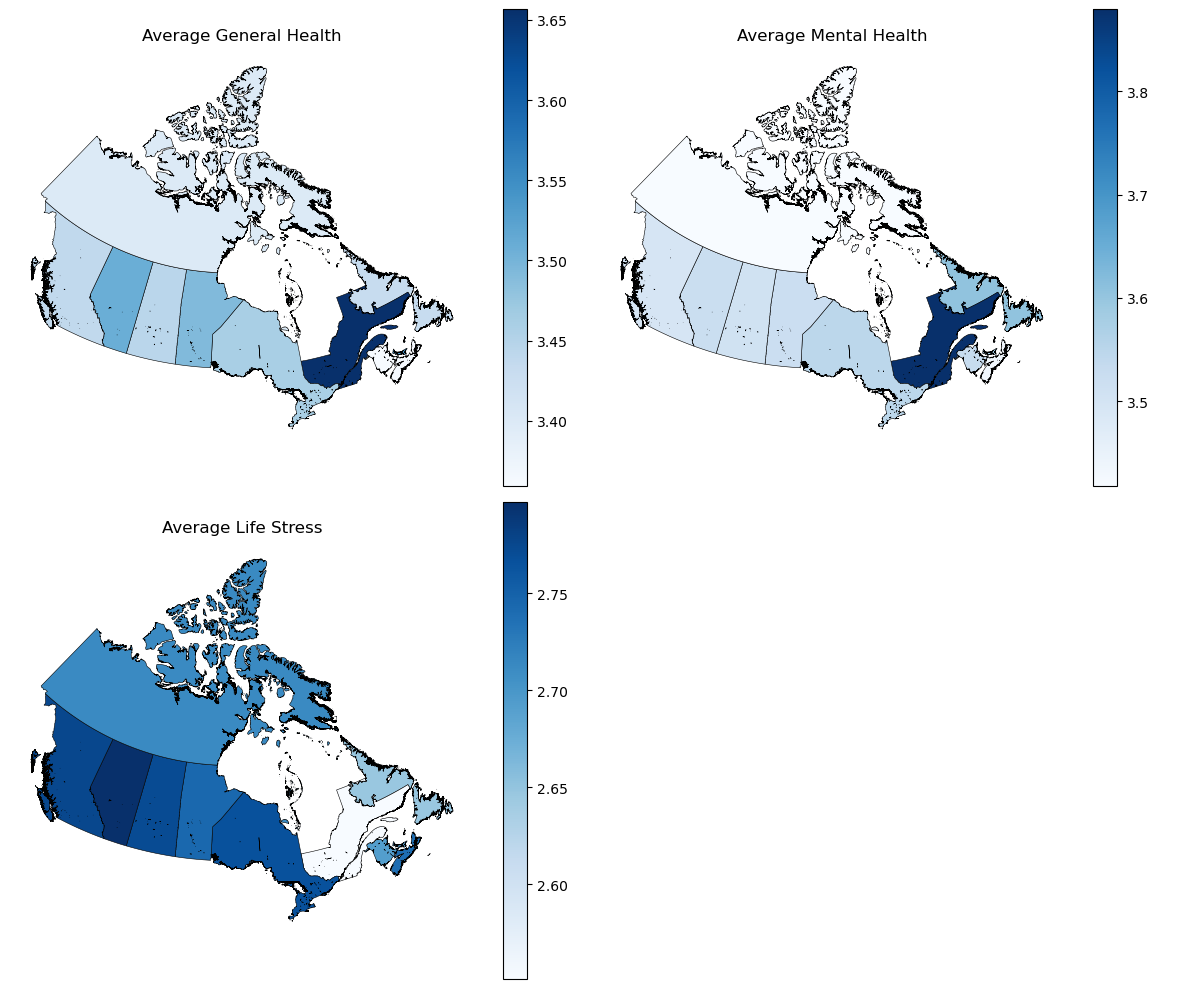

In [63]:
# Plot the maps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

variables = ['gen_health_num', 'mental_health_num', 'life_stress_num']
titles = ['Average General Health', 'Average Mental Health', 'Average Life Stress']

for ax, var, title in zip(axes, variables, titles):
    province_map_mean_val.plot(
        column=var,
        cmap='Blues',
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.4
    )
    ax.set_title(title)
    ax.axis('off')

# Hide the unused fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

The maps show that self-perceived general health, mental health, and stress vary only slightly across provinces and territories (a range of roughly 0.3–0.4 on a 1–5 scale). Because these differences are small, this suggests that other factors — such as demographics and lifestyle — may have a stronger influence on these variables (see v1).

Still, some patterns appear:

- **Quebec** shows slightly better self-perceived general and mental health, and lower stress levels compared to other provinces.
- **Alberta** shows comparatively good general health and average mental health, but also the highest reported stress levels.

Overall, no clear pattern emerges at the provincial level.

### Health regions level

The next step is to plot the average general health, mental health, and stress perception across the health regions. The mean values for each health region will be calculated, merged into the geospatial dataframe, and then plotted.

In [67]:
# Calculate health-region-level means
hr_means = cchs.groupby('hr_grouped').agg({
    'gen_health_num': 'mean',
    'mental_health_num': 'mean',
    'life_stress_num': 'mean'
}).reset_index()

# Check the result
hr_means.head()

,hr_grouped,gen_health_num,mental_health_num,life_stress_num
0,10911,3.448198,3.568694,2.731982
1,10912,3.346062,3.620525,2.639618
2,10913,3.469925,3.654135,2.511278
3,11900,3.541451,3.585492,2.689119
4,12901,3.276083,3.431782,2.741573


In [68]:
# Rename for consistency
hr_grouped_map = dissolved_map

In [69]:
# Create a health-region-level map of mean values
hr_grouped_map_mean_val = hr_grouped_map.merge(
    hr_means,
    on='hr_grouped',
    how='left'
)

# Check the result
hr_grouped_map_mean_val.head()

,hr_grouped,geometry,HR_UID,ENGNAME,FRENAME,DGUID,province_id,province_name,gen_health_num,mental_health_num,life_stress_num
0,10911,"MULTIPOLYGON (((8824242.14 1951992.691, 882423...",1011,Eastern Regional Health Authority,Eastern Regional Health Authority,2022A00071011,10,Newfoundland and Labrador,3.448198,3.568694,2.731982
1,10912,"MULTIPOLYGON (((8653694.163 2184578.891, 86537...",1012,Central Regional Health Authority,Central Regional Health Authority,2022A00071012,10,Newfoundland and Labrador,3.346062,3.620525,2.639618
2,10913,"MULTIPOLYGON (((7688582.289 2895378.786, 76886...",1013,Western Regional Health Authority,Western Regional Health Authority,2022A00071013,10,Newfoundland and Labrador,3.469925,3.654135,2.511278
3,11900,"MULTIPOLYGON (((8265314.709 1617815.76, 826500...",1100,Prince Edward Island,Île-du-Prince-Édouard,2022A00071100,11,Prince Edward Island,3.541451,3.585492,2.689119
4,12901,"MULTIPOLYGON (((8268113.909 1250012.751, 82681...",1201,Zone 1 - Western,Zone 1 - Western,2022A00071201,12,Nova Scotia,3.276083,3.431782,2.741573


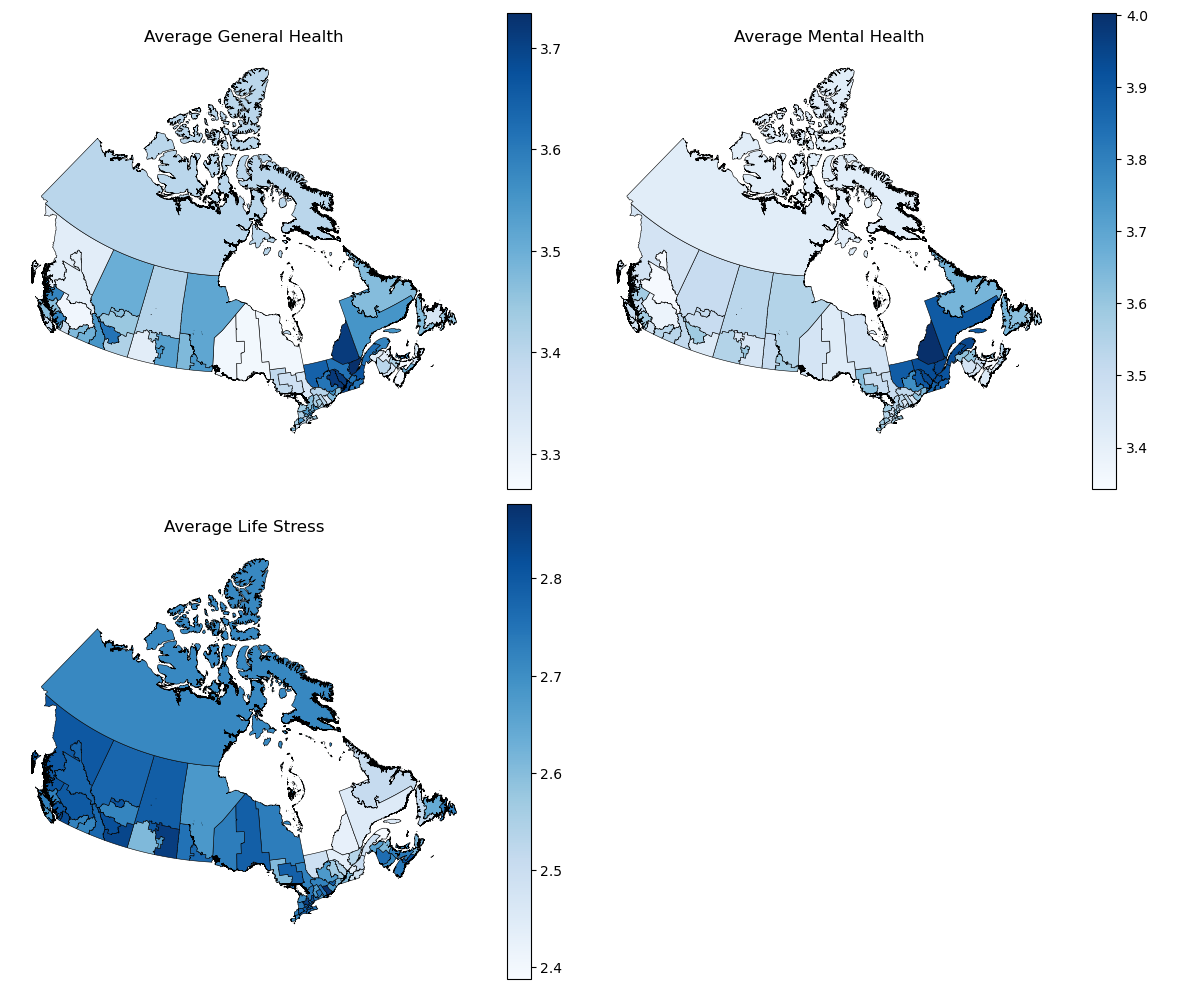

In [70]:
# Plot the maps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

variables = ['gen_health_num', 'mental_health_num', 'life_stress_num']
titles = ['Average General Health', 'Average Mental Health', 'Average Life Stress']

for ax, var, title in zip(axes, variables, titles):
    hr_grouped_map_mean_val.plot(
        column=var,
        cmap='Blues',
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.4
    )
    ax.set_title(title)
    ax.axis('off')

# Hide the unused fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

Average self-perceived general health, mental health, and stress levels across Canadian health regions show slightly more variation than at the provincial level (approximately 0.4–0.6 on a 1–5 scale).

Health regions in Quebec generally follow the provincial-level pattern, with slightly higher perceived general and mental health and lower perceived stress compared to many other regions. Variation between health regions within Quebec is minimal.

Beyond Quebec, no clear geographic patterns emerge in the perception of health, mental health, or stress. Differences do not appear to be related to the size of health regions or their north–south location.

### Provinces with largest urban centres

The final step of the analysis focuses on comparing the perception of general health, mental health, and stress in the four provinces with the largest cities: Ontario, Quebec, Alberta, and British Columbia. This allows a closer examination of regions with the greatest contrasts in population density.

To simplify plotting, a helper function has been created for consistent visualization.

In [74]:
# Create a plotting function
def plot_province_maps(gdf, province):
    """
    Plots three choropleth maps (general health, mental health, stress)
    for a single Canadian province.
    """
    subset = gdf[gdf['province_name'] == province]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    variables = ['gen_health_num', 'mental_health_num', 'life_stress_num']
    titles = ['Average General Health', 'Average Mental Health', 'Average Life Stress']

    for ax, var, title in zip(axes, variables, titles):
        subset.plot(
            column=var,
            cmap='Blues',
            legend=True,
            ax=ax,
            edgecolor='black',
            linewidth=0.4
        )
        ax.set_title(f"{title} – {province}")
        ax.axis('off')

    # hide the unused fourth subplot
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

#### Ontario

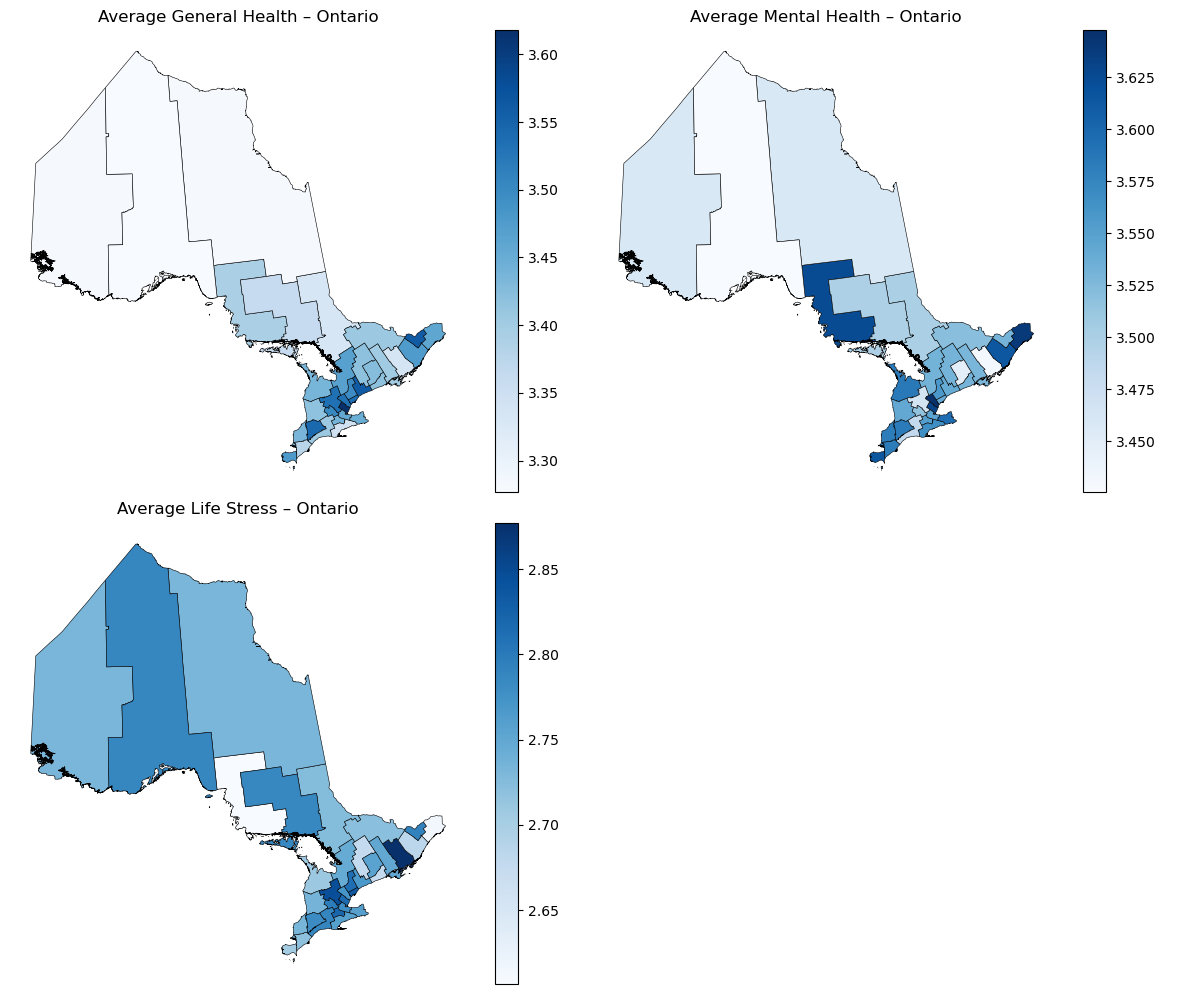

In [76]:
plot_province_maps(hr_grouped_map_mean_val, "Ontario")

The range of average responses across the province is approximately 0.2–0.3, indicating low variation. Still, general and mental health are perceived as slightly better in the densely populated southeastern regions, which include Toronto and Ottawa. At the same time, there is no clear pattern in the distribution of stress across Ontario.

#### Quebec

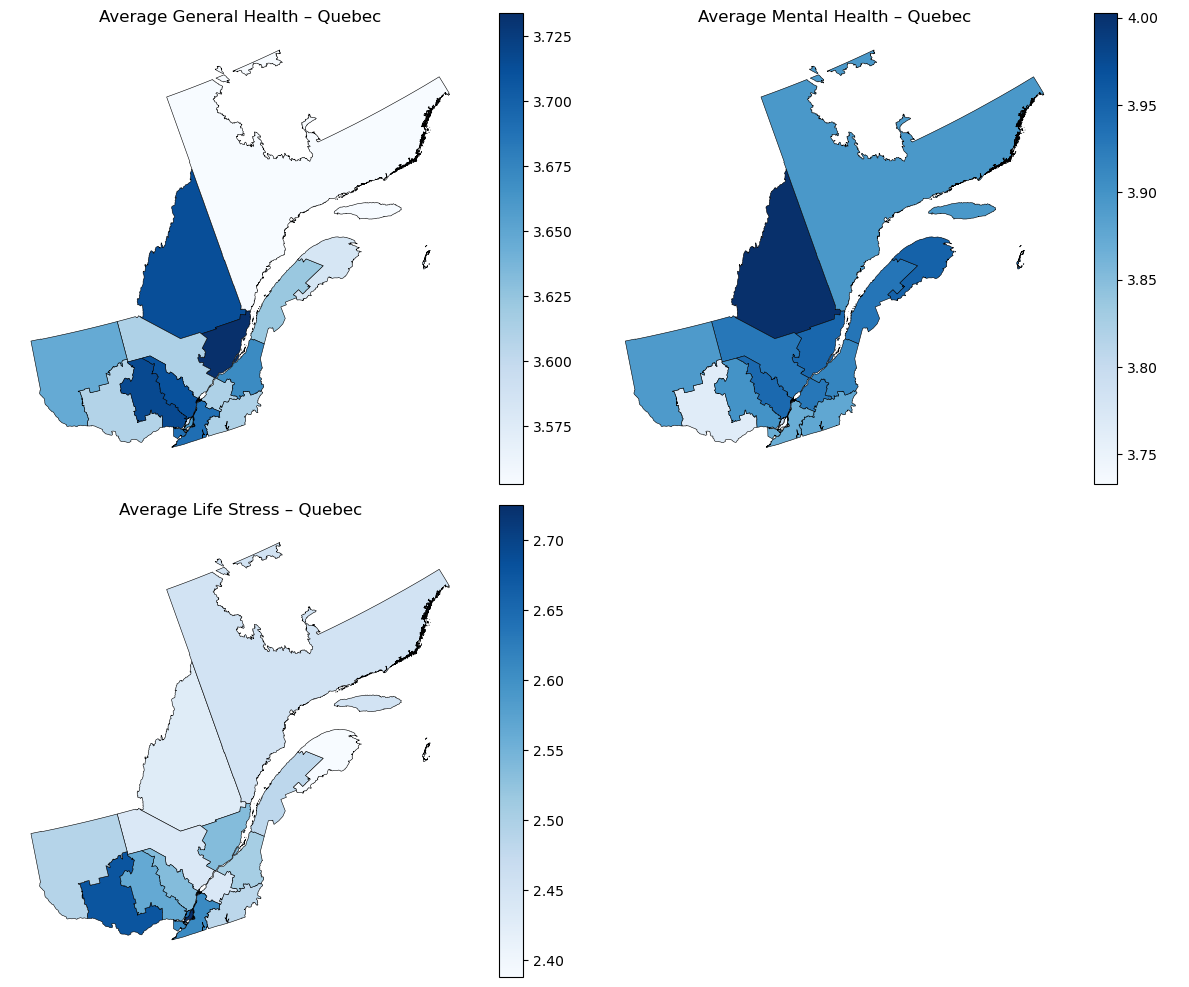

In [78]:
plot_province_maps(hr_grouped_map_mean_val, "Quebec")

Across the province, the range of average responses is approximately 0.2–0.3, indicating low variation. General health is perceived as slightly worse in northeastern Quebec, while stress levels are higher in the southern health regions. 

The correlation between better general and mental health and lower stress levels is evident in some health regions, supporting the conclusions drawn at the provincial level. However, some health regions do not follow this pattern.


#### Alberta

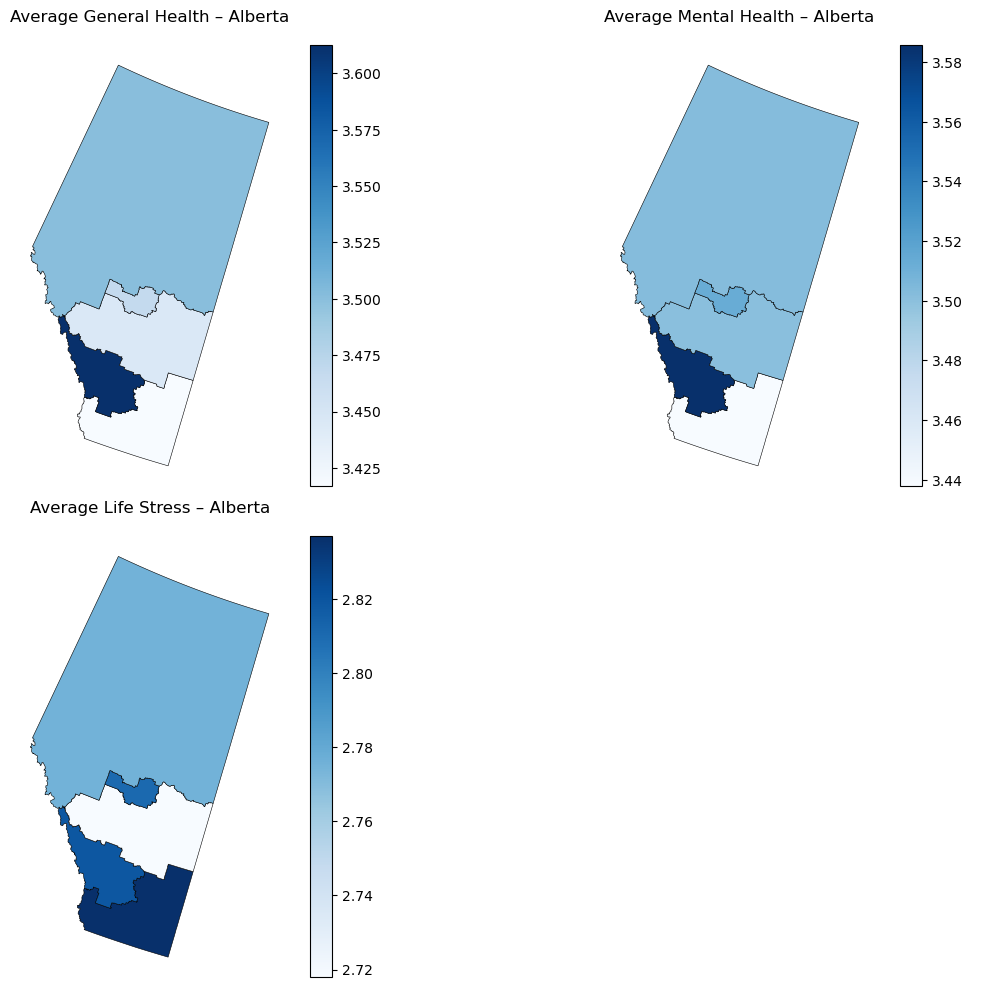

In [80]:
plot_province_maps(hr_grouped_map_mean_val, "Alberta")

Alberta shows low variation in responses across the health regions (0.2–0.3 on the 1–5 scale). General and mental health are perceived as better in Calgary and the surrounding area, but stress levels are comparatively high.

In Edmonton, stress levels are similar, while the perception of general and mental health is slightly worse.

The northern regions are around the provincial average on all three parameters. In the southeastern regions, worse perceptions of both general and mental health coincide with the highest stress levels across the province.

#### British Columbia

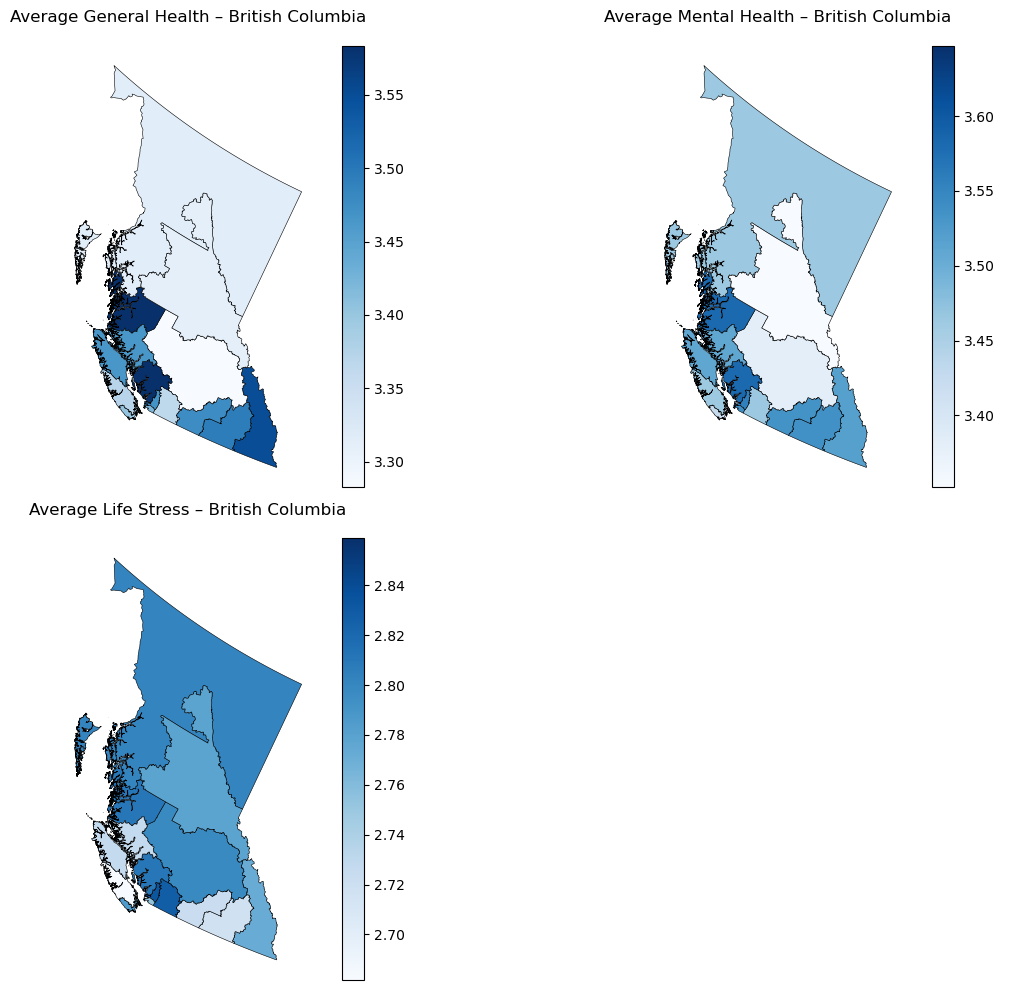

In [82]:
plot_province_maps(hr_grouped_map_mean_val, "British Columbia")

The variation of responses is low, ranging between 0.2 and 0.3 on the 1–5 scale.

Health regions along the coast and southern border show slightly higher satisfaction with general and mental health, although some other regions also show this to a lesser extent.

Differences in stress are not large, but stress levels are somewhat higher in Vancouver and in rural areas toward the north and east.

## Conclusion

Geospatial analysis of self-perceived general health, mental health, and stress levels shows little variation across provinces and territories (approximately 0.3–0.4 on a 1–5 scale), and only slightly higher variation across Canadian health regions (approximately 0.4–0.6 on a 1–5 scale). These small differences suggest that geography has low explanatory power for perceived health and stress, implying that other factors likely play a stronger role.

On the national level, health regions in Quebec show slightly better general and mental health as well as lower stress levels. Health regions in Northeastern Quebec and Newfoundland and Labrador show the lowest stress levels compared to other parts of Canada.

There is no clear or consistent relationship between stress levels and population density at the national scale, and this measure varies across provinces with the largest urban centres.

Finally, examining general and mental health across Ontario, Quebec, Alberta, and British Columbia shows that more positive responses tend to cluster in health regions with higher population density and larger urban areas located closer to the southern border.

#### Saving files

In [87]:
# Check CRS
print(hr_map.crs)
print(hr_grouped_map_mean_val.crs)
print(province_map_mean_val.crs)

None
None
None


In [88]:
# Reset CRS
province_map_mean_val = province_map_mean_val.set_crs(epsg=3347)
hr_grouped_map_mean_val = hr_grouped_map_mean_val.set_crs(epsg=3347)
# Check CRS
print(province_map_mean_val.crs)
print(hr_grouped_map_mean_val.crs)

EPSG:3347
EPSG:3347


In [89]:
# Save geopackages
province_map_mean_val.to_file(
    "/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/Stress_Levels_v2_gdfs/province_map_mean_val.gpkg",
    driver="GPKG"
)

hr_grouped_map_mean_val.to_file(
    "/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/Stress_Levels_v2_gdfs/hr_grouped_map_mean_val.gpkg",
    driver="GPKG"
)

In [90]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Save shapefiles
province_map_mean_val.to_file(
    "/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/Stress_Levels_v2_gdfs/province_map_mean_val.shp",
    driver="ESRI Shapefile"
)

hr_grouped_map_mean_val.to_file(
    "/Users/alex/Documents/Work/Projects for portfolio/Stress Levels/Stress_Levels_v2_gdfs/hr_grouped_map_mean_val.shp",
    driver="ESRI Shapefile"
)